In [1]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta
# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)
print(parent_dir)

# Change the directory to the parent directory
os.chdir(parent_dir)
# Add parent path for import
from data_loader.forecast_dataloader import ForecastDataset, de_normalized
pd.set_option('display.max_columns', 50)

/home/users/arash/anaconda3/envs/pyg/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/tank/users/arash/NGA Project/POI_paper/busyness_graph


In [7]:
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

WINDOW_SIZE = 24
HORIZON = 6
NORM_METHOD = 'z_score'
DATASET = 'New York'
START_POI = 0
END_POI = 40
BATCH_SIZE = 1
START_DATE = '2018-12-31'

TOTAL_DAYS = 400

CAT_COLS = ['top_category', 'sub_category']

RESULT_TRAIN_FILE = f'./output/{DATASET}/train_{START_POI}_{END_POI}'
RESULT_TEST_FILE = f'./output/{DATASET}/test_{START_POI}_{END_POI}'

In [8]:
date_format = r'%Y-%m-%d'
start_time = datetime.strptime(START_DATE, date_format)
end_time = start_time + timedelta(days=TOTAL_DAYS)
start_time, end_time

(datetime.datetime(2018, 12, 31, 0, 0), datetime.datetime(2020, 2, 4, 0, 0))

In [9]:
train_days = int(TRAIN_RATIO * TOTAL_DAYS)
valid_days = int(TOTAL_DAYS * VALID_RATIO)
test_days = TOTAL_DAYS - train_days - valid_days

time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()
valid_dates = time_span[train_days*24 + WINDOW_SIZE:(train_days + valid_days)*24 - HORIZON + 1]
test_dates = time_span[(train_days + valid_days)*24 + WINDOW_SIZE: - HORIZON + 1]
time_span

/tmp/ipykernel_11973/1954976777.py:5: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  time_span = pd.date_range(start_time, end_time, freq='1H', closed='left').to_numpy()


array(['2018-12-31T00:00:00.000000000', '2018-12-31T01:00:00.000000000',
       '2018-12-31T02:00:00.000000000', ...,
       '2020-02-03T21:00:00.000000000', '2020-02-03T22:00:00.000000000',
       '2020-02-03T23:00:00.000000000'], dtype='datetime64[ns]')

In [10]:
test_dates.shape

(931,)

In [11]:
df = pd.read_pickle(f'./cache_data/data-{START_POI}-{END_POI}-{TOTAL_DAYS}-{DATASET}.pkl')
# df = df.iloc[START_POI:END_POI]

data = pd.DataFrame(df["visits_by_each_hour"].to_list()).T

# split data
days = int(data.shape[0] / 24)

train_days = int(TRAIN_RATIO * days)
valid_days = int(days*VALID_RATIO)
test_days = days-train_days-valid_days

train_data = data[:train_days*24]
valid_data = data[train_days*24:(train_days + valid_days)*24]
test_data = data[(train_days + valid_days)*24:(train_days + valid_days+test_days)*24]

with open(os.path.join(RESULT_TRAIN_FILE, 'norm_stat.json'),'r') as f:
    normalize_statistic = json.load(f)


test_set = ForecastDataset(test_data, window_size=WINDOW_SIZE, 
                            horizon=HORIZON,
                            normalize_method=NORM_METHOD, 
                            norm_statistic=normalize_statistic)

test_loader = torch_data.DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=False,
                                    shuffle=False, num_workers=0)

valid_set = ForecastDataset(valid_data, window_size=WINDOW_SIZE, horizon=HORIZON,
                            normalize_method=NORM_METHOD, norm_statistic=normalize_statistic)
valid_loader = torch_data.DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = torch.load(f'./output/{DATASET}/train_{START_POI}_{END_POI}/39_stemgnn.pt')

In [12]:
def get_sample_by_datetime(datetime_str, test_dates, test_loader):
    datetime_input = datetime.strptime(datetime_str, '%Y-%m-%d %H:%M:%S')
    datetime_input_np = np.datetime64(datetime_input)

    for i, data in enumerate(test_loader):
        if test_dates[i] == datetime_input_np:
            return data

    raise ValueError("Datetime not found in test_dates array.")

In [13]:
test_dates

array(['2019-12-27T00:00:00.000000000', '2019-12-27T01:00:00.000000000',
       '2019-12-27T02:00:00.000000000', '2019-12-27T03:00:00.000000000',
       '2019-12-27T04:00:00.000000000', '2019-12-27T05:00:00.000000000',
       '2019-12-27T06:00:00.000000000', '2019-12-27T07:00:00.000000000',
       '2019-12-27T08:00:00.000000000', '2019-12-27T09:00:00.000000000',
       '2019-12-27T10:00:00.000000000', '2019-12-27T11:00:00.000000000',
       '2019-12-27T12:00:00.000000000', '2019-12-27T13:00:00.000000000',
       '2019-12-27T14:00:00.000000000', '2019-12-27T15:00:00.000000000',
       '2019-12-27T16:00:00.000000000', '2019-12-27T17:00:00.000000000',
       '2019-12-27T18:00:00.000000000', '2019-12-27T19:00:00.000000000',
       '2019-12-27T20:00:00.000000000', '2019-12-27T21:00:00.000000000',
       '2019-12-27T22:00:00.000000000', '2019-12-27T23:00:00.000000000',
       '2019-12-28T00:00:00.000000000', '2019-12-28T01:00:00.000000000',
       '2019-12-28T02:00:00.000000000', '2019-12-28

### Wednesday, Jan 22, 2020 10:00:00 AM (Lunch time in weekday)

In [14]:
x, y = get_sample_by_datetime('2020-01-22 10:00:00', test_dates, test_loader)
x.shape, y.shape

(torch.Size([1, 24, 50]), torch.Size([1, 6, 50]))

In [15]:
model.eval()
with torch.no_grad():
    forecast_result, _, (adj_mat_thresholded, adj_mat_unthresholded, embed_att, dist_adj, mhead_att_mat) = model(x)

In [16]:
adj_mat_thresholded = adj_mat_thresholded.cpu().numpy()
adj_mat_unthresholded = adj_mat_unthresholded.cpu().numpy()
embed_att = embed_att.cpu().numpy()
dist_adj = dist_adj.cpu().numpy()
mhead_att_mat = mhead_att_mat.cpu().numpy()

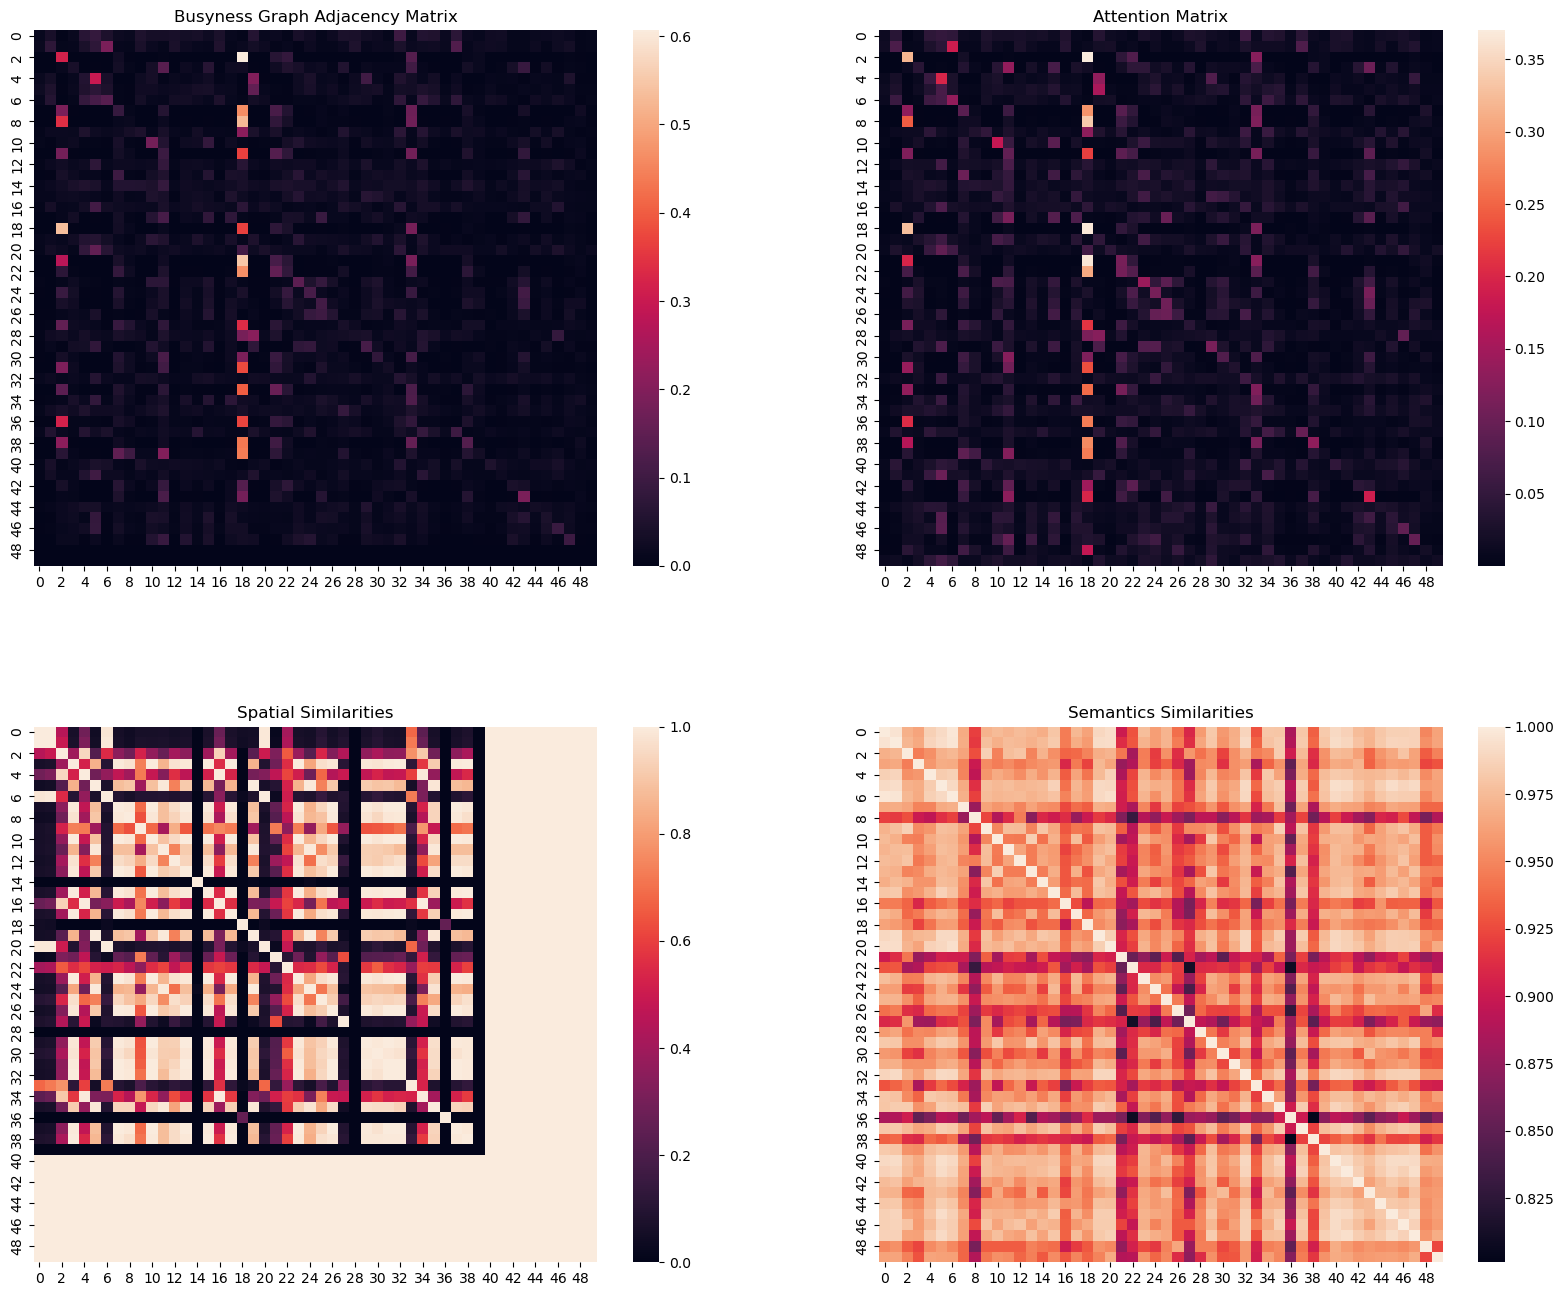

<Figure size 640x480 with 0 Axes>

In [17]:
# Create a figure and set the layout
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# Plot adj_mat_thresholded
sns.heatmap(adj_mat_thresholded, ax=axs[0, 0])
axs[0, 0].set_title('Busyness Graph Adjacency Matrix')

# Plot embed_att
sns.heatmap(embed_att, ax=axs[1, 1])
axs[1, 1].set_title('Semantics Similarities')

# Plot dist_adj
sns.heatmap(dist_adj, ax=axs[1, 0])
axs[1, 0].set_title('Spatial Similarities')

# Plot mhead_att_mat
sns.heatmap(mhead_att_mat, ax=axs[0, 1])
axs[0, 1].set_title('Attention Matrix')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Show the plot
plt.show()
plt.savefig('ipynb/img/paper/heatmaps.pdf', format='pdf', transparent=True, dpi=300)


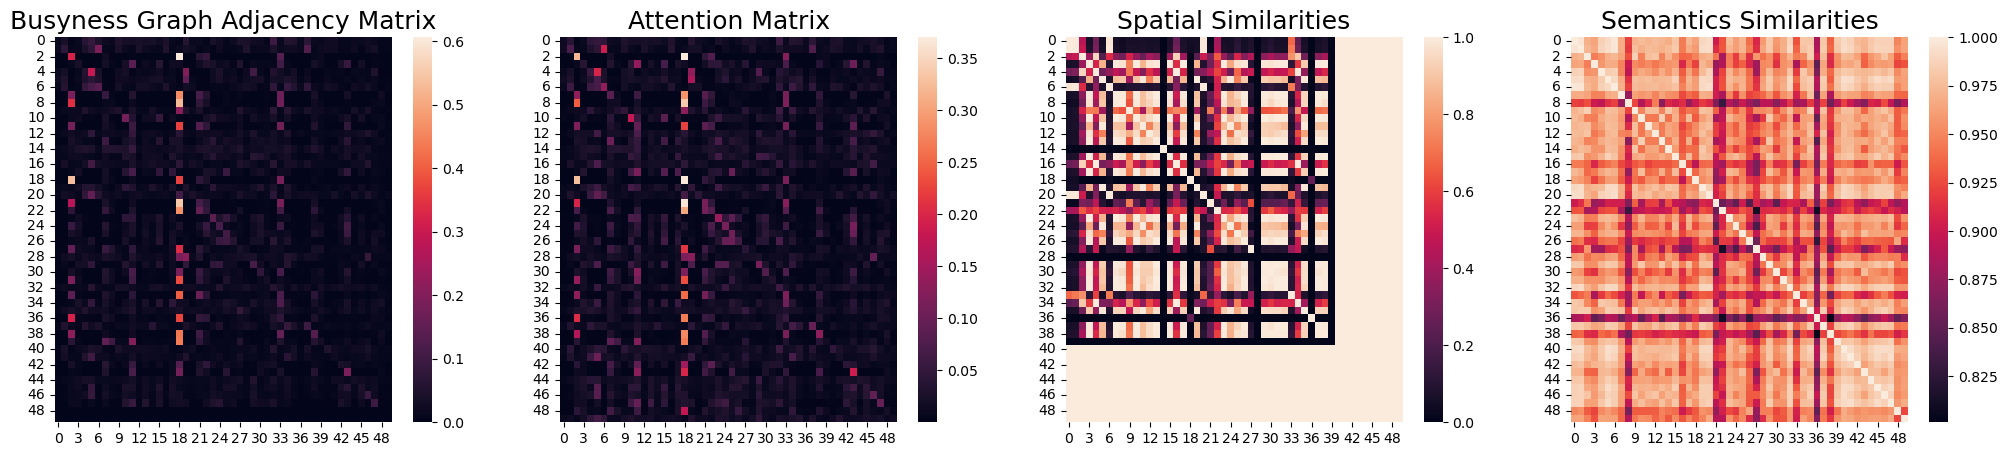

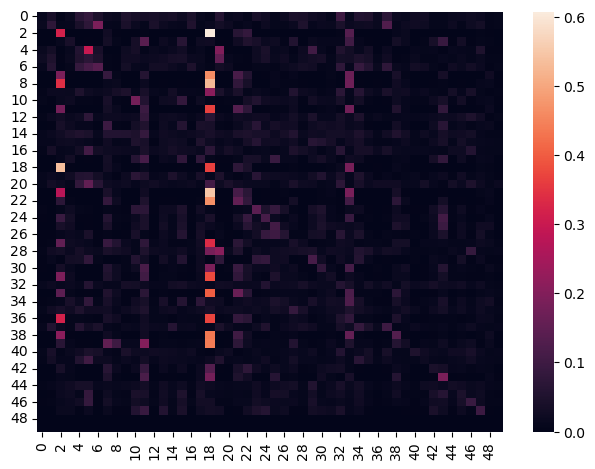

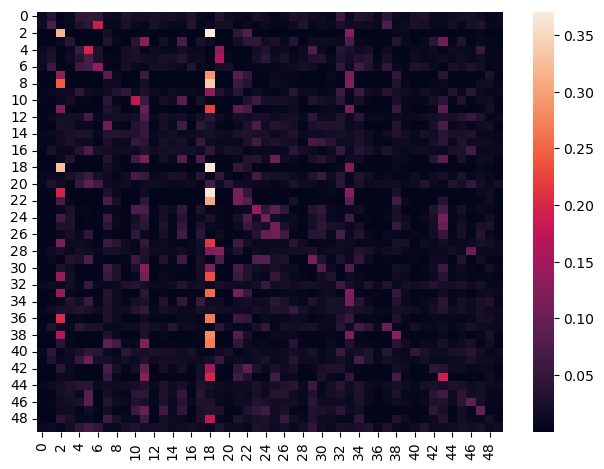

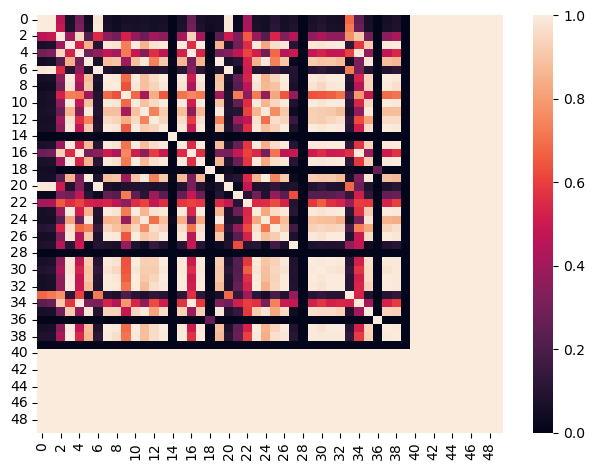

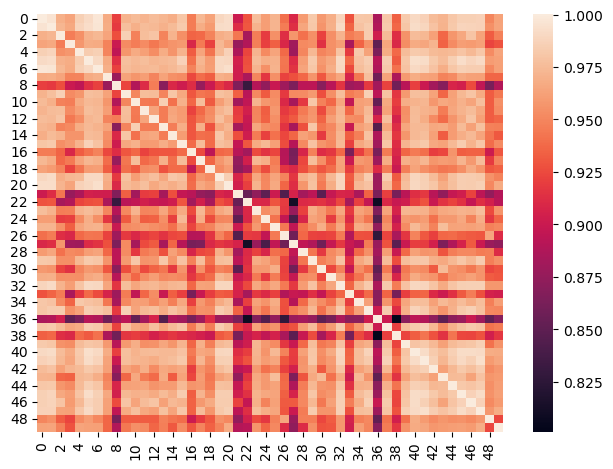

In [28]:
# Create a figure and set the layout
fig, axs = plt.subplots(1, 4, figsize=(25, 5))

# Plot adj_mat_thresholded
sns.heatmap(adj_mat_thresholded, ax=axs[0])
axs[0].set_title('Busyness Graph Adjacency Matrix', fontsize=18)

# Plot embed_att
sns.heatmap(embed_att, ax=axs[3])
axs[3].set_title('Semantics Similarities', fontsize=18)

# Plot dist_adj
sns.heatmap(dist_adj, ax=axs[2])
axs[2].set_title('Spatial Similarities', fontsize=18)

# Plot mhead_att_mat
sns.heatmap(mhead_att_mat, ax=axs[1])
axs[1].set_title('Attention Matrix', fontsize=18)


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

heatmap_titles = ['busyness_graph_adjacency_matrix', 'attention_matrix', 'spatial_similarities', 'semantics_similarities']
heatmaps = [adj_mat_thresholded, mhead_att_mat, dist_adj, embed_att]

# Show the plot
# plt.savefig('ipynb/img/paper/heatmaps.pdf', format='pdf', transparent=True, dpi=300)
for i, ax in enumerate(axs):
    fig, ax = plt.subplots()
    sns.heatmap(ax=ax, data=heatmaps[i])
    # ax.set_title('Subplot {}'.format(i+1))
    plt.tight_layout()
    plt.savefig(f'ipynb/img/paper/heatmap_{heatmap_titles[i]}.pdf', format='pdf', transparent=True, dpi=300)
    # plt.close(fig)


Shape of cross-correlation matrix: (50, 50)
Shape of the submatrix: (50, 50)


<AxesSubplot: >

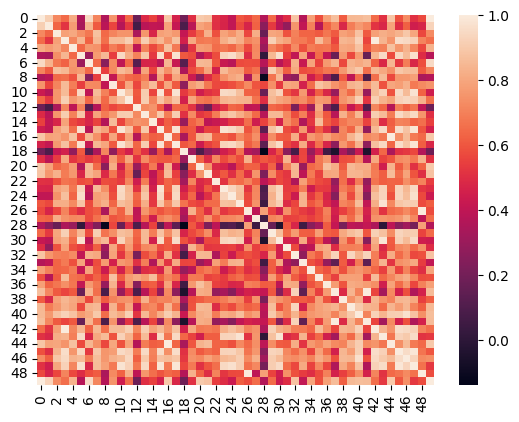

In [87]:
# Calculate the cross-correlation matrix
cross_corr_matrix = np.corrcoef(x[0], rowvar=False)

# Print the shape of the cross-correlation matrix
print("Shape of cross-correlation matrix:", cross_corr_matrix.shape)

# Alternatively, if you want to extract a specific 50x50 submatrix from the cross-correlation matrix
submatrix = cross_corr_matrix[:50, :50]
print("Shape of the submatrix:", submatrix.shape)
sns.heatmap(cross_corr_matrix)

In [88]:
def find_similar_elements(adj_mat, embed_att, dist_adj, mhead_att, adj_threshold, embed_threshold, dist_threshold, att_threshold):
    # Find indices where all conditions are satisfied
    indices = np.where(
        (adj_mat > adj_threshold) & 
        (embed_att < embed_threshold) & 
        (dist_adj < dist_threshold) & 
        (mhead_att > att_threshold)
    )
    
    # Extract the row and column indices
    row_indices, col_indices = indices
    
    # Create a list of tuples with the matching indices
    matching_elements = list(zip(row_indices, col_indices))
    
    return matching_elements

def find_dissimilar_elements(adj_mat, embed_att, dist_adj, mhead_att, adj_threshold, embed_threshold, dist_threshold, att_threshold):
    # Find indices where all conditions are satisfied
    indices = np.where(
        (adj_mat < adj_threshold) & 
        (embed_att > embed_threshold) & 
        (dist_adj < dist_threshold) & 
        (mhead_att < att_threshold)
    )
    
    # Extract the row and column indices
    row_indices, col_indices = indices
    
    # Create a list of tuples with the matching indices
    matching_elements = list(zip(row_indices, col_indices))
    
    return matching_elements

def find_common_tuples(list1, list2):
    common_tuples = [
        tuple1 for tuple1 in list1
        for tuple2 in list2
        if any(elem in tuple2 for elem in tuple1)
    ]
    
    return common_tuples

# Example usage
thresholds = {
    'adj_threshold': 0.2,
    'embed_threshold': 0.99,
    'dist_threshold': 0.7,
    'att_threshold': 0.1
}

similar_elements = find_similar_elements(adj_mat_thresholded, embed_att, dist_adj, mhead_att_mat, **thresholds)
print(similar_elements)
# Example usage
thresholds = {
    'adj_threshold': 0.05,
    'embed_threshold': 0.99,
    'dist_threshold': 1,
    'att_threshold': 0.05
}

dissimilar_elements = find_dissimilar_elements(adj_mat_thresholded, embed_att, dist_adj, mhead_att_mat, **thresholds)
print(dissimilar_elements)


common = find_common_tuples(similar_elements, dissimilar_elements)
print(common)

[(2, 18), (4, 5), (7, 18), (8, 2), (8, 18), (9, 18), (11, 18), (18, 2), (21, 2), (21, 18), (22, 18), (27, 18), (28, 19), (31, 18), (33, 18), (36, 2), (36, 18), (38, 2), (38, 18), (39, 11), (39, 18)]
[(0, 1), (0, 6), (0, 20), (1, 0), (1, 19), (1, 20), (1, 32), (5, 0), (5, 1), (5, 6), (5, 32), (6, 0), (6, 19), (6, 20), (19, 1), (19, 6), (20, 0), (20, 1), (28, 28), (32, 1), (39, 39)]
[(4, 5), (4, 5), (4, 5), (4, 5), (28, 19), (28, 19), (28, 19), (28, 19), (28, 19), (39, 11), (39, 18)]


In [89]:
a, b, c = 28, 19, 6
# a, b, c = 28, 19, 1
df.iloc[[a, b, c]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
28,sg:d029c383b1bb4e839a7229e52085fd5f,"[468, 377, 404, 471, 458, 211, 166, 474, 464, ...","[2, 3, 1, 2, 1, 3, 6, 9, 12, 9, 4, 5, 7, 8, 26...",174849,Dunkin',625 8th Aveport Authority Bus Terminal,New York,NY,10018.0,US,SG_BRAND_9b4045db0fbb461cf9ed78916d9b16b4,Dunkin',NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,sg:255ff320f6c240c0bdd05d32b5e82f8c,"[398, 385, 421, 451, 473, 341, 307, 444, 400, ...","[5, 0, 3, 1, 6, 6, 9, 11, 14, 18, 7, 14, 22, 1...",209903,Westfield,185 Greenwich St,New York,NY,10007.0,US,SG_BRAND_4f881579635210fd,Westfield,NaN,Lessors of Real Estate,Malls,531120.0,40.711444,-74.011387,NaN,"{ ""Mon"": [[""10:00"", ""21:00""]], ""Tue"": [[""10:00...",NaN
6,sg:d9bb026222a746028763b10fef62aaca,"[1006, 1054, 1107, 1208, 1201, 1066, 1251, 113...","[13, 11, 14, 13, 35, 44, 48, 27, 6, 17, 16, 21...",491910,John F Kennedy International Airport Terminal 8,John F. Kennedy International Airport Terminal 8,New York,NY,11430.0,US,NaN,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,40.648692,-73.791021,NaN,NaN,NaN


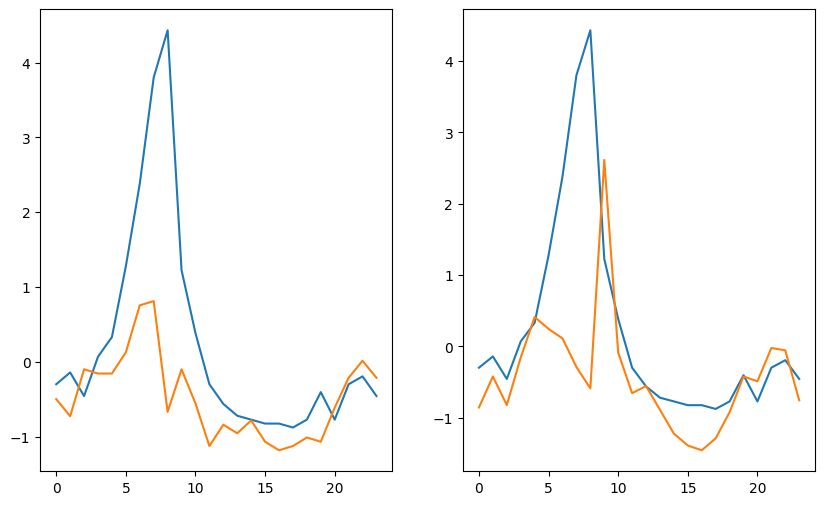

In [90]:
# plot the time series for POIs 33, 34, and 12 
# x = de_normalized(x.numpy(), NORM_METHOD, normalize_statistic)

fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(x[0, :, a])
ax[0].plot(x[0, :, b])
ax[1].plot(x[0, :, a])
ax[1].plot(x[0, :, c])

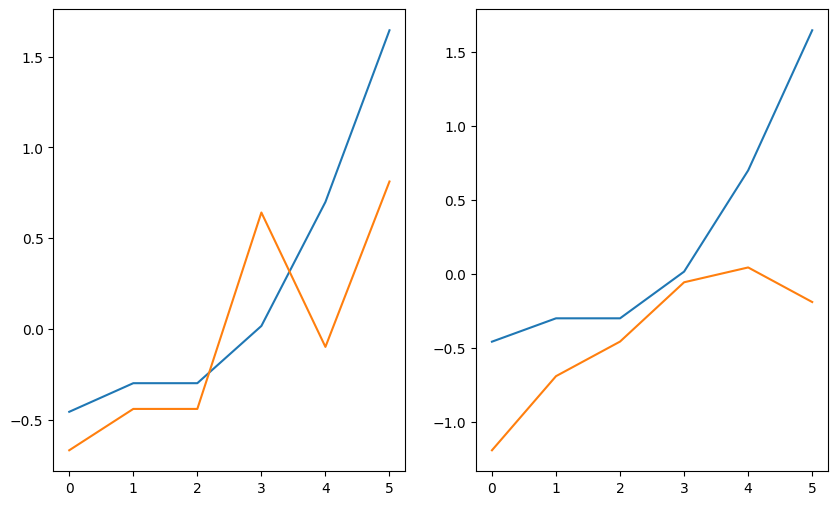

In [91]:
# plot the time series for POIs 33, 34, and 12 
# y = de_normalized(y.numpy(), NORM_METHOD, normalize_statistic)
fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(y[0, :, a])
ax[0].plot(y[0, :, b])
ax[1].plot(y[0, :, a])
ax[1].plot(y[0, :, c])

In [92]:
df[df.location_name.fillna('').str.contains('Golf')]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
10,sg:16ea842d2a8c43cc8c45e5a1b8a3556d,"[602, 764, 829, 877, 786, 328, 193, 696, 746, ...","[4, 2, 5, 4, 6, 3, 13, 15, 33, 34, 26, 23, 28,...",272513,Golf Manhattan,108 W 39th St,New York,NY,10018.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.753113,-73.986119,1.212685e+10,NaN,NaN
13,sg:ffc2a90ecada4641a43f287e7ec5a9ae,"[484, 552, 625, 638, 640, 420, 349, 566, 604, ...","[3, 4, 5, 1, 4, 5, 10, 12, 27, 31, 17, 16, 14,...",245967,Golf & Body NYC,883 Avenue of the Americas,New York,NY,10001.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.748422,-73.988968,1.212244e+10,NaN,NaN
15,sg:c2a3c1ab57fc49beb64277ee94e10b0e,"[491, 641, 709, 717, 584, 213, 118, 645, 697, ...","[0, 1, 3, 2, 2, 6, 17, 19, 15, 24, 20, 29, 27,...",234806,True Spec Golf The Vault NYC,5 E 42nd St,New York,NY,10017.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.753341,-73.979877,1.973465e+10,NaN,NaN
24,sg:6ea75fed9c15422f8ae46791da38f5a6,"[429, 548, 571, 604, 584, 166, 75, 584, 606, 5...","[1, 6, 1, 4, 5, 5, 16, 9, 25, 25, 31, 26, 29, ...",194078,Five Iron Golf Financial District,22 Stone St,New York,NY,10004.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.703923,-74.011861,1.917676e+10,"{ ""Mon"": [[""6:00"", ""23:00""]], ""Tue"": [[""6:00"",...",NaN
29,sg:ff3e20ef2bab4672af33e494877900d1,"[327, 408, 474, 496, 450, 322, 209, 427, 477, ...","[4, 5, 0, 0, 3, 5, 6, 12, 9, 13, 14, 10, 15, 1...",166121,Premier Indoor Golf,1 E 28th St,New York,NY,10016.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.744621,-73.986866,NaN,NaN,NaN


In [93]:
mhead_att_mat[10, 13]

0.021957738

In [94]:
a = 10
b = 23
c = 13
df.iloc[[a, b, c]]

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,safegraph_brand_ids,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
10,sg:16ea842d2a8c43cc8c45e5a1b8a3556d,"[602, 764, 829, 877, 786, 328, 193, 696, 746, ...","[4, 2, 5, 4, 6, 3, 13, 15, 33, 34, 26, 23, 28,...",272513,Golf Manhattan,108 W 39th St,New York,NY,10018.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.753113,-73.986119,1.212685e+10,NaN,NaN
23,sg:6bf963aa792e455c9ede44347f0ff95b,"[429, 519, 617, 570, 552, 152, 134, 577, 636, ...","[4, 5, 0, 1, 3, 3, 11, 6, 27, 36, 20, 14, 16, ...",194831,International Council of Shopping Centers,1221 Avenue of the Americas,New York,NY,10020.0,US,NaN,NaN,NaN,Lessors of Real Estate,Malls,531120.0,40.759420,-73.982207,1.646728e+10,NaN,NaN
13,sg:ffc2a90ecada4641a43f287e7ec5a9ae,"[484, 552, 625, 638, 640, 420, 349, 566, 604, ...","[3, 4, 5, 1, 4, 5, 10, 12, 27, 31, 17, 16, 14,...",245967,Golf & Body NYC,883 Avenue of the Americas,New York,NY,10001.0,US,NaN,NaN,NaN,Other Amusement and Recreation Industries,Golf Courses and Country Clubs,713910.0,40.748422,-73.988968,1.212244e+10,NaN,NaN


In [95]:
fig = px.scatter_mapbox(
    df.iloc[[a, b, c]], 
    lat="latitude", 
    lon="longitude", 
    hover_name="location_name", 
    hover_data=["phone_number", "open_hours"], 
    zoom=10
)

# Set the map style
fig.update_layout(mapbox_style="open-street-map")

# Update the marker properties
fig.update_traces(marker=dict(size=10, opacity=0.7))

# Show the plot
fig.show()

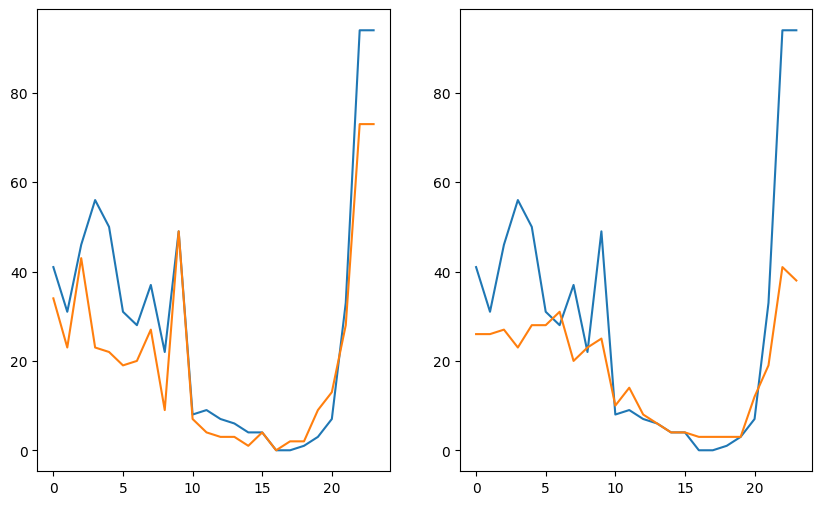

In [103]:
# plot the time series for POIs 33, 34, and 12 
x = de_normalized(x.numpy(), NORM_METHOD, normalize_statistic)

fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(x[0, :, a])
ax[0].plot(x[0, :, b])
ax[1].plot(x[0, :, a])
ax[1].plot(x[0, :, c])

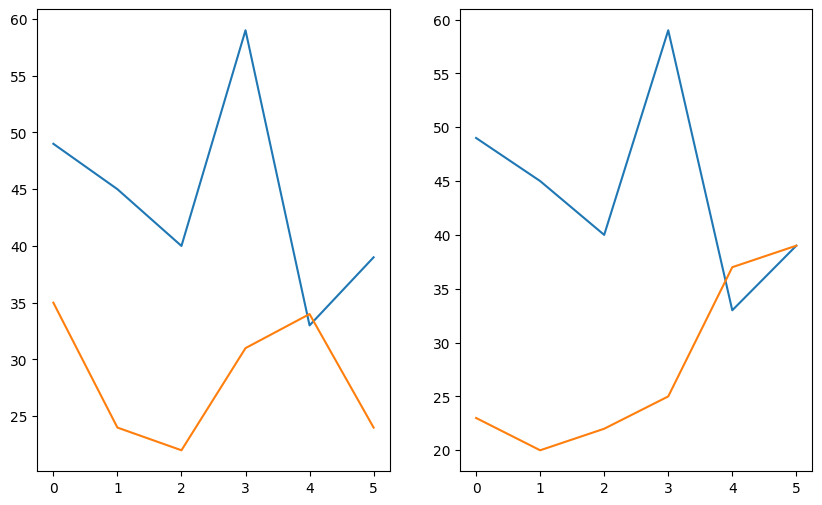

In [104]:
# plot the time series for POIs 33, 34, and 12 
y = de_normalized(y.numpy(), NORM_METHOD, normalize_statistic)
fig, ax = plt.subplots(1, 2,figsize=(10, 6))
ax[0].plot(y[0, :, a])
ax[0].plot(y[0, :, b])
ax[1].plot(y[0, :, a])
ax[1].plot(y[0, :, c])

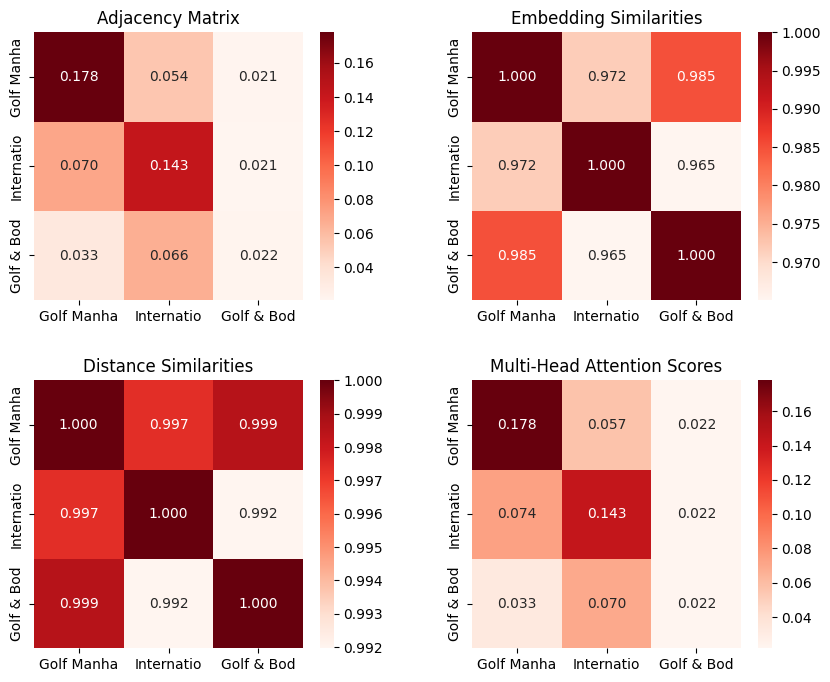

In [102]:
# Assuming you have the following variables:
target_pois = [a, b, c]  # Indices of target POIs
target_labels = df.iloc[target_pois].location_name.str[:10]  # Labels for target POIs

# Create a figure and set the layout
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot adj_mat_thresholded
sns.heatmap(adj_mat_thresholded[np.ix_(target_pois, target_pois)], fmt='.3f', annot=True, annot_kws={'size': 10},
            cmap='Reds', ax=axs[0, 0], xticklabels=target_labels, yticklabels=target_labels)
axs[0, 0].set_title('Adjacency Matrix')

# Plot embed_att
sns.heatmap(embed_att[np.ix_(target_pois, target_pois)], fmt='.3f', annot=True, annot_kws={'size': 10},
            cmap='Reds', ax=axs[0, 1], xticklabels=target_labels, yticklabels=target_labels)
axs[0, 1].set_title('Embedding Similarities')

# Plot dist_adj
sns.heatmap(dist_adj[np.ix_(target_pois, target_pois)], fmt='.3f', annot=True, annot_kws={'size': 10},
            cmap='Reds', ax=axs[1, 0], xticklabels=target_labels, yticklabels=target_labels)
axs[1, 0].set_title('Distance Similarities')

# Plot mhead_att_mat
sns.heatmap(mhead_att_mat[np.ix_(target_pois, target_pois)], fmt='.3f', annot=True, annot_kws={'size': 10},
            cmap='Reds', ax=axs[1, 1], xticklabels=target_labels, yticklabels=target_labels)
axs[1, 1].set_title('Multi-Head Attention Scores')


# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()
